In [3]:
# Question to answer: what factors correlate strongest with high gross or high rating?
# Plot gross against relevant factors, then plot rating against relevant factors, and describe the relationships.
# Plot country of origin on map.
# Use machine learning (linear regression, random forests, support vector machine) to make a model that predicts gross or rating.

import re
import string
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup

#Get the URL
r = requests.get('http://www.imdb.com/chart/top?ref_=nv_mv_250_6')
#Get text from the URL
html = r.text
#Use BeautifulSoup to read and parse the data to lxml
soup = BeautifulSoup(html, 'lxml')

movies = soup.select('td.titleColumn')
links = [a.attrs.get('href') for a in soup.select('td.titleColumn a')]
directorAndActors = [a.attrs.get('title') for a in soup.select('td.titleColumn a')]
ratings = [b.attrs.get('data-value') for b in soup.select('td.posterColumn span[name=ir]')]
ids = [b.attrs.get('data-tconst') for b in soup.select('td.watchlistColumn div[class=wlb_ribbon]')]

resultList = []
linkList = []
idList = []
for i in range(0, len(movies)):
    tempList = []
    movie_string = movies[i].get_text()
    movie = (' '.join(movie_string.split()).replace('.', ''))
    movie_title = movie[len(str(i))+1:-7]
    year = re.search('\((.*?)\)', movie_string).group(1)
    
    if (i < 10):
        rank = movie[0]
    elif (i < 100):
        rank = movie[0]+movie[1]
    else:
        rank = movie[0]+movie[1]+movie[2]
        
    director = directorAndActors[i].split(",")
    director = director[0].split(" (")
    
    tempList.append(int(rank))
    tempList.append(movie_title)
    tempList.append(int(year))
    tempList.append(director[0])
    tempList.append(float(ratings[i]))
    
    idList.append(ids[i])
    
    tempR = requests.get("http://www.imdb.com"+links[i])
    tempHtml = tempR.text 
    tempSoup = BeautifulSoup(tempHtml, 'lxml')

    rateVotes = tempSoup.select('span[class=small]')
    tempList.append(int(rateVotes[0].get_text().replace(',', '')))
    
    budget = tempSoup.select('div.txt-block')
    for n in range(0, len(budget)):
        if (str(budget[n].getText().split("h4")).find("udget") > -1 and
           str(budget[n].getText().split("h4")).find("$") > -1):
            tempList.append(int(str(budget[n].getText().split("h4")).split("$")[1].split(" ")[0].replace(',', '')))
            break
            
        if (n == len(budget)-1):
            tempList.append(0)
            break
    
    gross = tempSoup.select('div.txt-block')
    for o in range(0, len(gross)):
        if (str(gross[o].getText().split("h4")).find("ross") > -1 and
           str(gross[o].getText().split("h4")).find("$") > -1):
            tempList.append(int(str(gross[o].getText().split("h4")).split("$")[1].split(" ")[0].replace(',', '')))
            break
            
        if (o == len(gross)-2):
            tempList.append(0)
            break

    genres = tempSoup.select('span[itemprop=genre]')
    tempstr = ""
    for j in range(0, len(genres)):
        tempstr = tempstr + genres[j].get_text() +", "
    tempList.append(tempstr)

    writers = tempSoup.select('div.credit_summary_item span[itemprop=creator]')
    tempstr = ""
    for q in range(0, len(writers)):
        tempstr = tempstr + writers[q].get_text().split("\n")[1].split(" (")[0]+", "
    tempList.append(tempstr)

    stars = tempSoup.select('div.credit_summary_item span[itemprop=actors]')
    tempstr = ""
    for k in range(0, len(stars)):
        tempstr = tempstr + stars[k].get_text().split("\n")[1].strip()+" "
    tempList.append(tempstr)
    
    country = tempSoup.select('div.txt-block a[itemprop=url]')
    tempstr = ""
    for l in range(0, len(country)):
        if (str(country[l]).find("/title?country_of_origin") > -1):
            tempstr = tempstr + country[l].getText()+", "
    tempList.append(tempstr)
    
    color = tempSoup.select('div.txt-block a[itemprop=url]')
    for m in range(0, len(color)):
        if (str(color[m]).find("/title?colors") > -1):
            tempList.append(color[m].getText())
            break
    
    production = tempSoup.select('div.txt-block span[itemprop=name]')
    tempstr = ""
    for p in range(0, len(production)):
        tempstr = tempstr + production[p].getText()+", "
    tempList.append(tempstr)
    
    linkList.append("http://www.imdb.com/"+links[i])
    resultList.append(tempList)

data_columns = ["rank","title","year","director","rating", "votes","budget","gross","genres",
                "writers","actors","country","color","production_co"]
# Create a dataframe with Pandas
df = pd.DataFrame(resultList, columns=data_columns)

# Show the output
df

,rank,title,year,director,rating,votes,budget,gross,genres,writers,actors,country,color,production_co
0,1,The Shawshank Redemption,1994,Frank Darabont,9.215802,1808998,25000000,28341469,"Crime, Drama,","Stephen King, Frank Darabont,","Tim Robbins, Morgan Freeman, Bob Gunton","USA,",Color,"Castle Rock Entertainment,"
1,2,The Godfather,1972,Francis Ford Coppola,9.161319,1235373,6000000,134821952,"Crime, Drama,","Mario Puzo, Francis Ford Coppola,","Marlon Brando, Al Pacino, James Caan","USA,",Color,"Paramount Pictures, Alfran Productions,"
2,3,The Godfather: Part II,1974,Francis Ford Coppola,8.998488,850119,13000000,57300000,"Crime, Drama,","Francis Ford Coppola, Mario Puzo,","Al Pacino, Robert De Niro, Robert Duvall","USA,",Color,"Paramount Pictures, The Coppola Company,"
3,4,The Dark Knight,2008,Christopher Nolan,8.948637,1789113,185000000,533316061,"Action, Crime, Drama,","Jonathan Nolan, Christopher Nolan,","Christian Bale, Heath Ledger, Aaron Eckhart","USA, UK,",Color,"Warner Bros., Legendary Entertainment, Syncopy,"
4,5,12 Angry Men,1957,Sidney Lumet,8.899431,489929,350000,0,"Crime, Drama,","Reginald Rose, Reginald Rose,","Henry Fonda, Lee J. Cobb, Martin Balsam","USA,",Black and White,"Orion-Nova Productions,"
5,6,Schindler's List,1993,Steven Spielberg,8.896253,928497,22000000,96067179,"Biography, Drama, History,","Thomas Keneally, Steven Zaillian,","Liam Neeson, Ralph Fiennes, Ben Kingsley","USA,",Black and White,"Universal Pictures, Amblin Entertainment,"
6,7,Pulp Fiction,1994,Quentin Tarantino,8.876066,1416303,8000000,107930000,"Crime, Drama,","Quentin Tarantino, Roger Avary,","John Travolta, Uma Thurman, Samuel L. Jackson","USA,",Color,"Miramax, A Band Apart, Jersey Films,"
7,8,The Lord of the Rings: The Return of the King,2003,Peter Jackson,8.866934,1297522,94000000,377019252,"Adventure, Drama, Fantasy,","J.R.R. Tolkien, Fran Walsh,","Elijah Wood, Viggo Mortensen, Ian McKellen","USA, New Zealand,",Color,"New Line Cinema, WingNut Films, The Saul Zaent..."
8,9,"The Good, the Bad and the Ugly",1966,Sergio Leone,8.843230,537045,1200000,6100000,"Western,","Luciano Vincenzoni, Sergio Leone,","Clint Eastwood, Eli Wallach, Lee Van Cleef","Italy, Spain, West Germany,",Color,"Produzioni Europee Associati (PEA), Arturo Gon..."
9,1,Fight Club,1999,David Fincher,8.796835,1448820,63000000,37023395,"Drama,","Chuck Palahniuk, Jim Uhls,","Brad Pitt, Edward Norton, Meat Loaf","USA, Germany,",Color,"Fox 2000 Pictures, Regency Enterprises, Linson..."


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Remove rows where votes, budget, or gross is missing, to ensure we are using a
# consistent set of data for each plot.
complete_df = df.loc[(df['votes'] > 0) & (df['budget'] > 0) & (df['gross'] > 0)]
complete_df

,rank,title,year,director,rating,votes,budget,gross,genres,writers,actors,country,color,production_co
0,1,The Shawshank Redemption,1994,Frank Darabont,9.215802,1808998,25000000,28341469,"Crime, Drama,","Stephen King, Frank Darabont,","Tim Robbins, Morgan Freeman, Bob Gunton","USA,",Color,"Castle Rock Entertainment,"
1,2,The Godfather,1972,Francis Ford Coppola,9.161319,1235373,6000000,134821952,"Crime, Drama,","Mario Puzo, Francis Ford Coppola,","Marlon Brando, Al Pacino, James Caan","USA,",Color,"Paramount Pictures, Alfran Productions,"
2,3,The Godfather: Part II,1974,Francis Ford Coppola,8.998488,850119,13000000,57300000,"Crime, Drama,","Francis Ford Coppola, Mario Puzo,","Al Pacino, Robert De Niro, Robert Duvall","USA,",Color,"Paramount Pictures, The Coppola Company,"
3,4,The Dark Knight,2008,Christopher Nolan,8.948637,1789113,185000000,533316061,"Action, Crime, Drama,","Jonathan Nolan, Christopher Nolan,","Christian Bale, Heath Ledger, Aaron Eckhart","USA, UK,",Color,"Warner Bros., Legendary Entertainment, Syncopy,"
5,6,Schindler's List,1993,Steven Spielberg,8.896253,928497,22000000,96067179,"Biography, Drama, History,","Thomas Keneally, Steven Zaillian,","Liam Neeson, Ralph Fiennes, Ben Kingsley","USA,",Black and White,"Universal Pictures, Amblin Entertainment,"
6,7,Pulp Fiction,1994,Quentin Tarantino,8.876066,1416303,8000000,107930000,"Crime, Drama,","Quentin Tarantino, Roger Avary,","John Travolta, Uma Thurman, Samuel L. Jackson","USA,",Color,"Miramax, A Band Apart, Jersey Films,"
7,8,The Lord of the Rings: The Return of the King,2003,Peter Jackson,8.866934,1297522,94000000,377019252,"Adventure, Drama, Fantasy,","J.R.R. Tolkien, Fran Walsh,","Elijah Wood, Viggo Mortensen, Ian McKellen","USA, New Zealand,",Color,"New Line Cinema, WingNut Films, The Saul Zaent..."
8,9,"The Good, the Bad and the Ugly",1966,Sergio Leone,8.843230,537045,1200000,6100000,"Western,","Luciano Vincenzoni, Sergio Leone,","Clint Eastwood, Eli Wallach, Lee Van Cleef","Italy, Spain, West Germany,",Color,"Produzioni Europee Associati (PEA), Arturo Gon..."
9,1,Fight Club,1999,David Fincher,8.796835,1448820,63000000,37023395,"Drama,","Chuck Palahniuk, Jim Uhls,","Brad Pitt, Edward Norton, Meat Loaf","USA, Germany,",Color,"Fox 2000 Pictures, Regency Enterprises, Linson..."
10,11,The Lord of the Rings: The Fellowship of the Ring,2001,Peter Jackson,8.769039,1318773,93000000,313837577,"Adventure, Drama, Fantasy,","J.R.R. Tolkien, Fran Walsh,","Elijah Wood, Ian McKellen, Orlando Bloom","New Zealand, USA,",Color,"New Line Cinema, WingNut Films, The Saul Zaent..."


### Ratings against IMDb votes

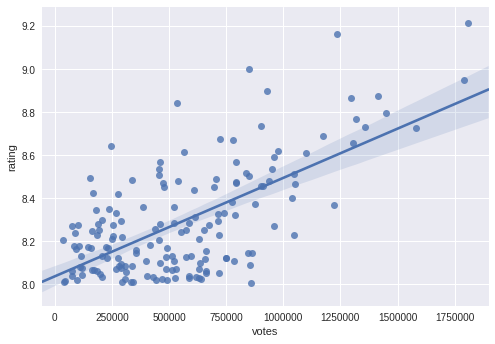

In [21]:
ax = sns.regplot(x="votes", y="rating", data=complete_df)
sns.plt.show()

At a glance, this plot appears to have a much stronger correlation and with a tighter spread than the other plots. This probably means that people are more likely to rate the movie on a review site like IMDd if they internally rate the movie high, and less likely to rate if they internally rate the movie low.

### Ratings against budgets

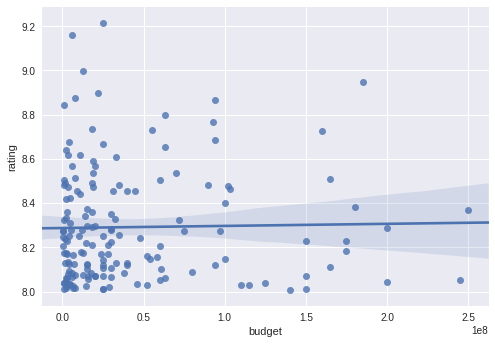

In [22]:
ax = sns.regplot(x="budget", y="rating", data=complete_df)
sns.plt.show()

The budget variable is heavily skewed and varies dramatically. Let's try a logarithmic scale for budget. It may make it easier to visualize.

### Ratings against gross revenues

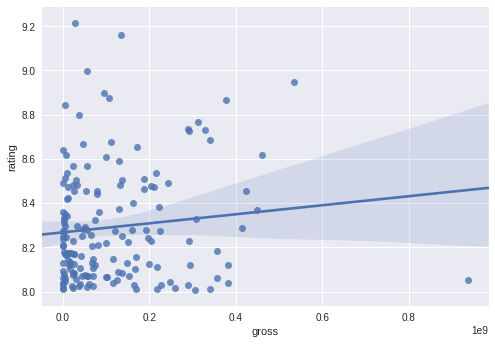

In [23]:
ax = sns.regplot(x="gross", y="rating", data=complete_df)
sns.plt.show()

Like budget, gross is another dollar value and varies dramatically. Another logarithmic scale on the gross axis might be of use here.